In [ ]:
# examineComputePhenotypes
# E Flynn
# 10/19/2017
#
# Code for examing and then computing derived phenotypes

In [47]:
setwd("/scratch/PI/mrivas/users/erflynn/sex_div_gwas")
require('ggplot2')

In [48]:
# load all the phenotypes
phe48 <- read.table("phefiles/48.phe") # WC
phe49 <- read.table("phefiles/49.phe") # HC
phe50 <- read.table("phefiles/50.phe") # height
phe21001 <- read.table("phefiles/21001.phe") # BMI
phe21002 <- read.table("phefiles/21002.phe") # weight
phe4079 <- read.table("phefiles/4079.phe") # bp-dia
phe4080 <- read.table("phefiles/4080.phe") # bp-sys
phe20150 <- read.table("phefiles/20150.phe") # FEV-1
phe3063 <- read.table("phefiles/3063.phe") # FVC
phe3064 <- read.table("phefiles/3064.phe") # PEF

In [49]:
sexLabelPheData <- function(pheDat){
    
    # load phenotype and sex labels
    onesex <- read.table('phefiles/onesex.keep')
    zerosex <- read.table('phefiles/zerosex.keep')
    
    pheDat2 <- pheDat[,c(1,3)]
    colnames(pheDat2) <- c("ID", "Phenotype")
    rownames(pheDat2) <- pheDat2$ID
    
    # extract m, f rows
    ids.male <- sapply(unlist(onesex$V1), as.character)
    m <- intersect(ids.male, rownames(pheDat2) )
    men <- pheDat2[m,]
    men$Sex <- 'M'
    ids.female <- sapply(unlist(zerosex$V1), as.character)
    f <- intersect(ids.female, rownames(pheDat2) )
    women <- pheDat2[f,]
    women$Sex <- 'F'
    
    # combine into a full table
    pheFull <- rbind(men, women)
    return(pheFull)
}


In [50]:
plotDensities <- function(trait.name, pheFull){
    pheFull <- sexLabelPheData(pheFull)
    ggplot(pheFull, aes(Phenotype, fill=Sex, colour=Sex))+ geom_density(alpha=0.1)+ theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
    panel.background = element_blank(), axis.line = element_line(colour = "black"))+ggtitle(trait.name)    
}


In [51]:
matchOrdering <- function(phe1, phe2, phe1.name, phe2.name){
    phe1$V1 <- sapply(phe1$V1, as.character)
    phe2$V1 <- sapply(phe2$V1, as.character)

    ### MATCH ORDERING

    overlapping <- intersect(phe1$V1, phe2$V1)
    print(sprintf("%s IDs for %s, %s IDs for %s, %s overlap", nrow(phe1), phe1.name, nrow(phe2), phe2.name, 
            length(overlapping)))
    rownames(phe1) <- phe1$V1
    rownames(phe2) <- phe2$V1

    phe1.o <- phe1[overlapping,]
    phe2.o <- phe2[overlapping,]
    stopifnot(rownames(phe1.o)==rownames(phe2.o))
    return(list("1"=phe1.o, "2"=phe2.o))
}

In [7]:
# --- WHR --- #
l <- matchOrdering(phe48, phe49, "WC", "HC")
phe48.o <- l$'1'
phe49.o <- l$'2'

whr <- phe48.o$V3/phe49.o$V3
pheWhr <- cbind(phe49.o[,1:2], whr)
write.table(pheWhr, file="phefiles/whr.phe", col.names=FALSE, row.names=FALSE, quote=FALSE)


[1] "500498 IDs for WC, 500436 IDs for HC, 500392 overlap"


In [52]:

# --- FEV-1/FVC --- #
l2 <- matchOrdering(phe20150, phe3063, "FEV-1", "FVC")
phe20150.o <- l2$'1'
phe3063.o <- l2$'2'

fp <- phe20150.o$V3/phe3063.o$V3
pheFP <- cbind(phe20150[,1:2], fp)


[1] "353388 IDs for FEV-1, 455903 IDs for FVC, 353388 overlap"


In [61]:
summary(phe20150.o$V3)
summary(phe3063.o$V3)
summary(pheFP$fp)

### restrict these to the 0.01% to 99.9% percentile - to avoid strange results (long tails!)
### not sure if I should be doing this, but this seemed to be more relevant
full <- cbind(phe20150.o, phe3063.o$V3, pheFP$fp)
colnames(full) <- c("ID", "ID2", "FEV", "FVC", "Ratio")

q1.FEV <- quantile(full$FEV, 0.001)
q2.FEV <- quantile(full$FEV, 0.999)
q1.FVC <- quantile(full$FVC, 0.001)
q2.FVC <- quantile(full$FVC, 0.999)

fev.filt.rows <- full$FEV >= q1.FEV & full$FEV <= q2.FEV
fvc.filt.rows <- full$FVC >= q1.FVC & full$FVC <= q2.FVC
table(fev.filt.rows)
table(fvc.filt.rows)

full <- full[fvc.filt.rows,]

summary(full)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.090   2.300   2.770   2.851   3.350  14.650 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.020   2.250   2.710   2.793   3.290  14.040 

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
  0.07317   1.00300   1.01300   1.02900   1.02900 180.50000 

fev.filt.rows
 FALSE   TRUE 
   698 352690 

fvc.filt.rows
 FALSE   TRUE 
   702 352686 

      ID                 ID2               FEV             FVC       
 Length:352686      Min.   :1000028   Min.   :0.090   Min.   :0.670  
 Class :character   1st Qu.:2256974   1st Qu.:2.300   1st Qu.:2.250  
 Mode  :character   Median :3516066   Median :2.770   Median :2.710  
                    Mean   :3514359   Mean   :2.849   Mean   :2.792  
                    3rd Qu.:4771001   3rd Qu.:3.350   3rd Qu.:3.290  
                    Max.   :6026237   Max.   :7.220   Max.   :5.510  
     Ratio        
 Min.   :0.07317  
 1st Qu.:1.00265  
 Median :1.01299  
 Mean   :1.02232  
 3rd Qu.:1.02913  
 Max.   :4.23711  

In [62]:
pheFP.f <- full[,c("ID", "ID2", "Ratio")]
write.table(pheFP.f, file="phefiles/FEV_FVC.phe", col.names=FALSE, row.names=FALSE, quote=FALSE)

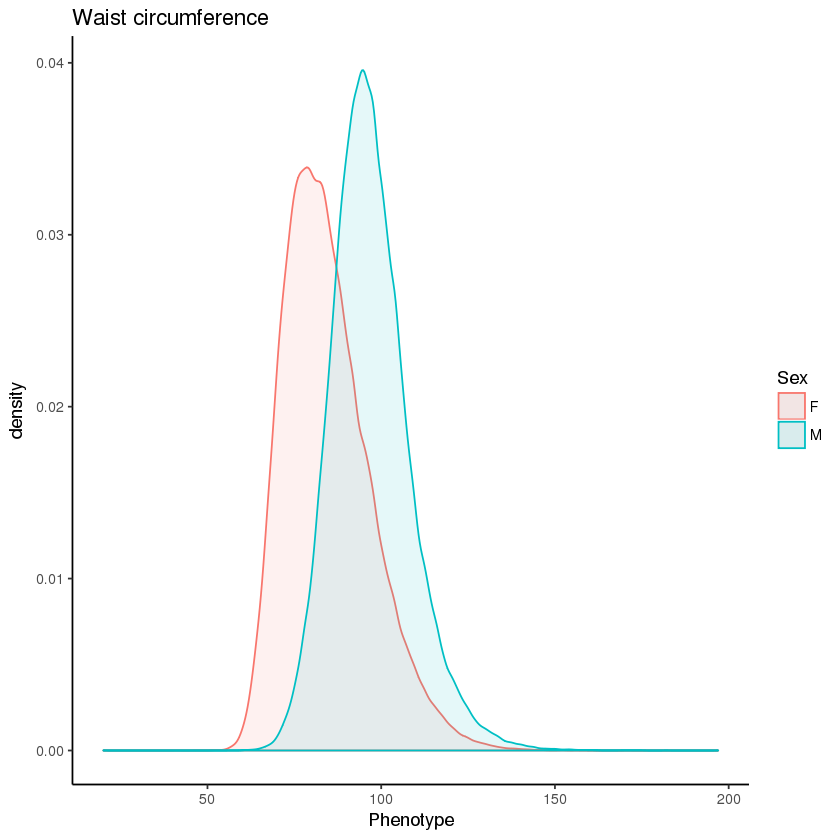

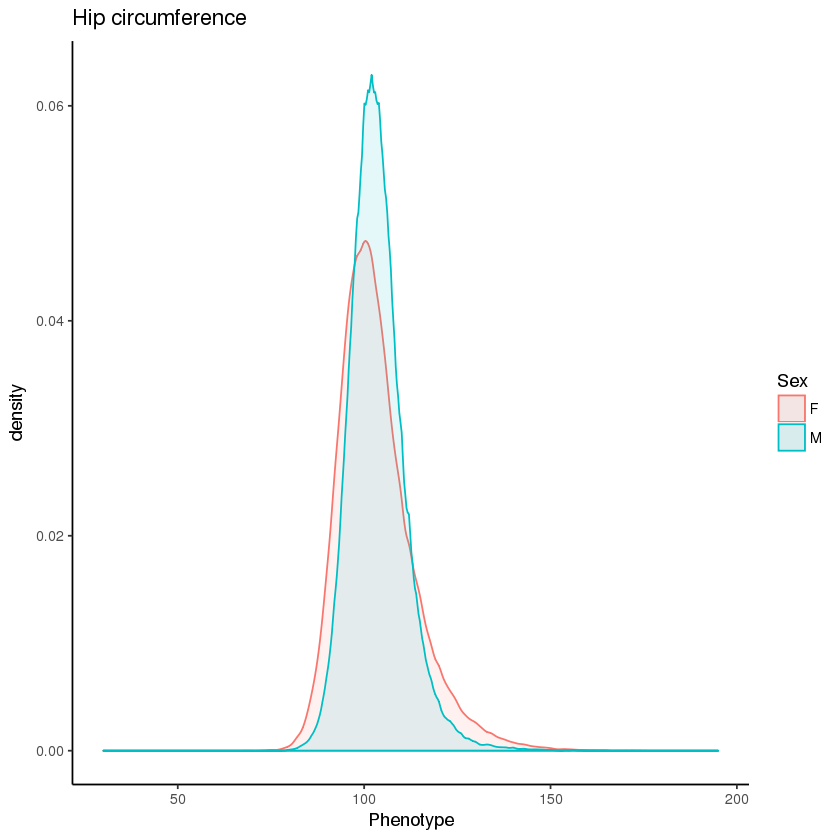

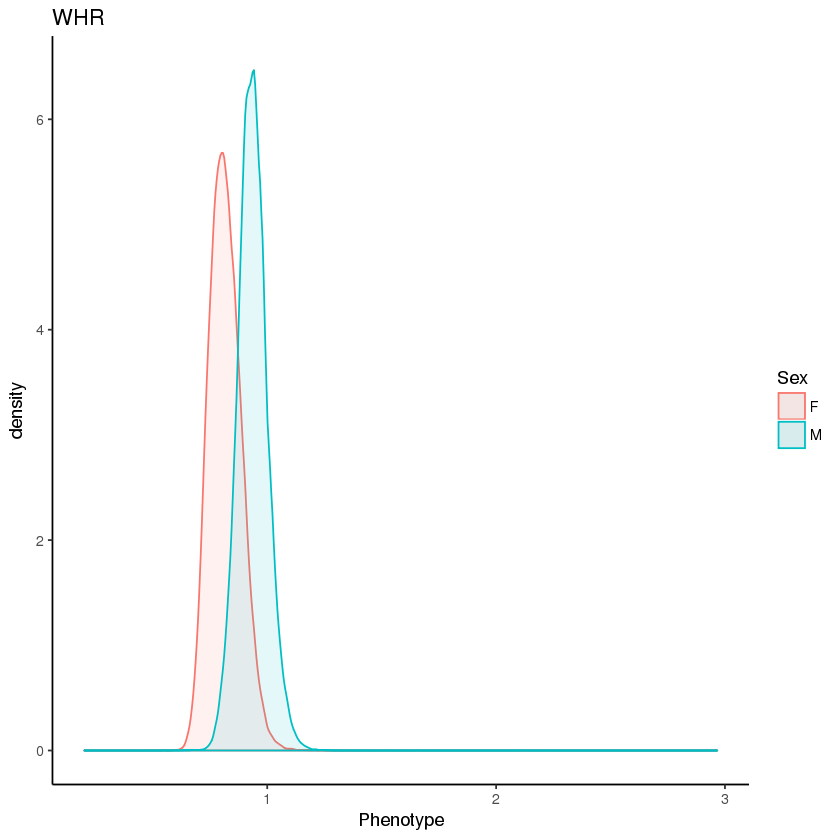

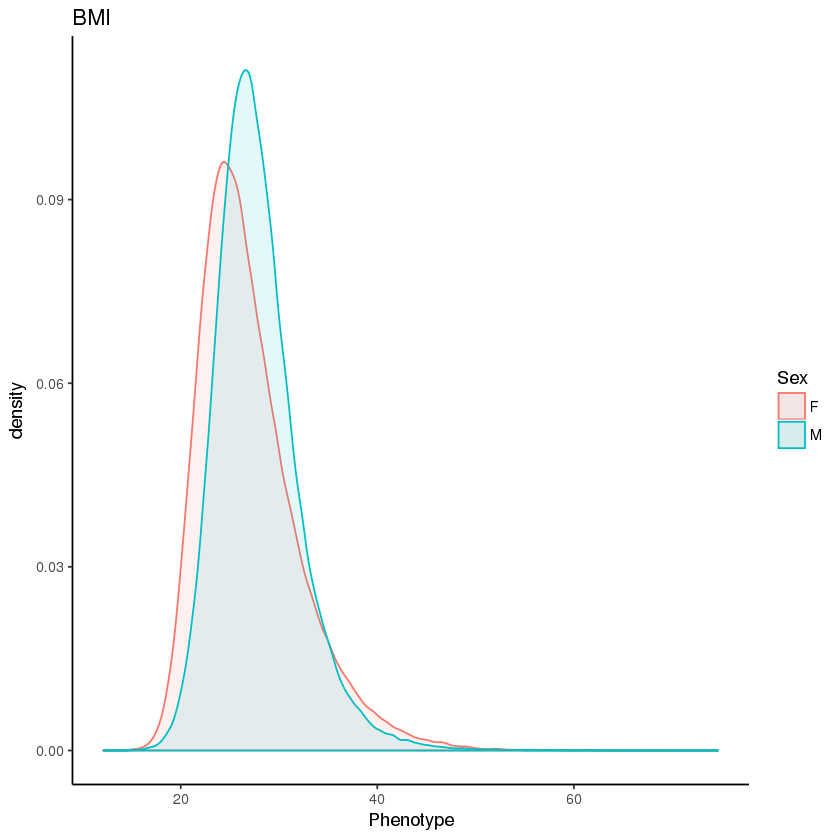

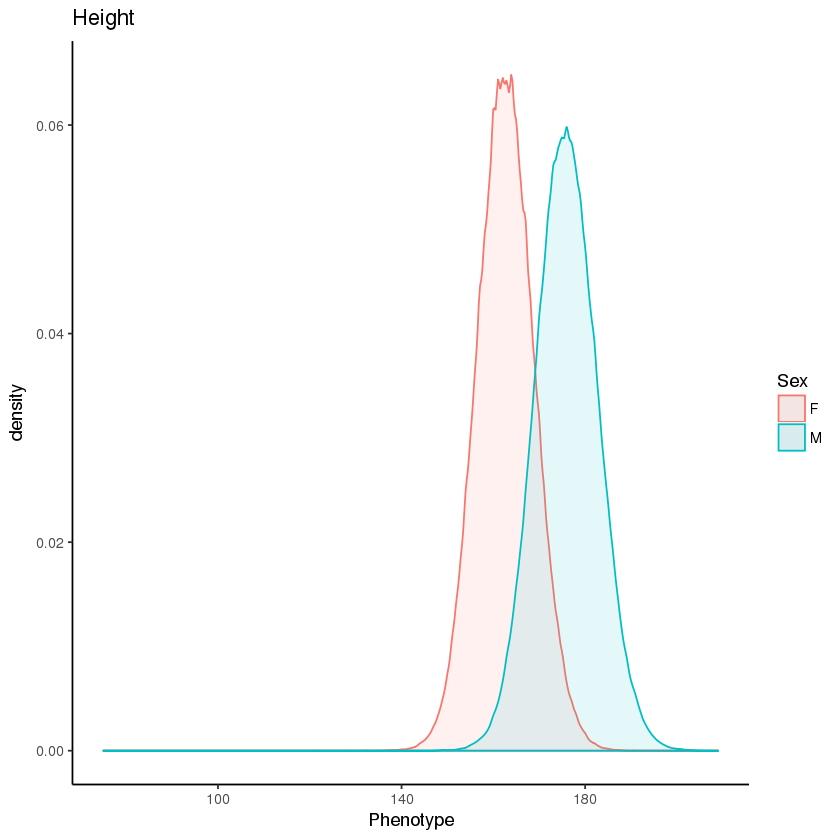

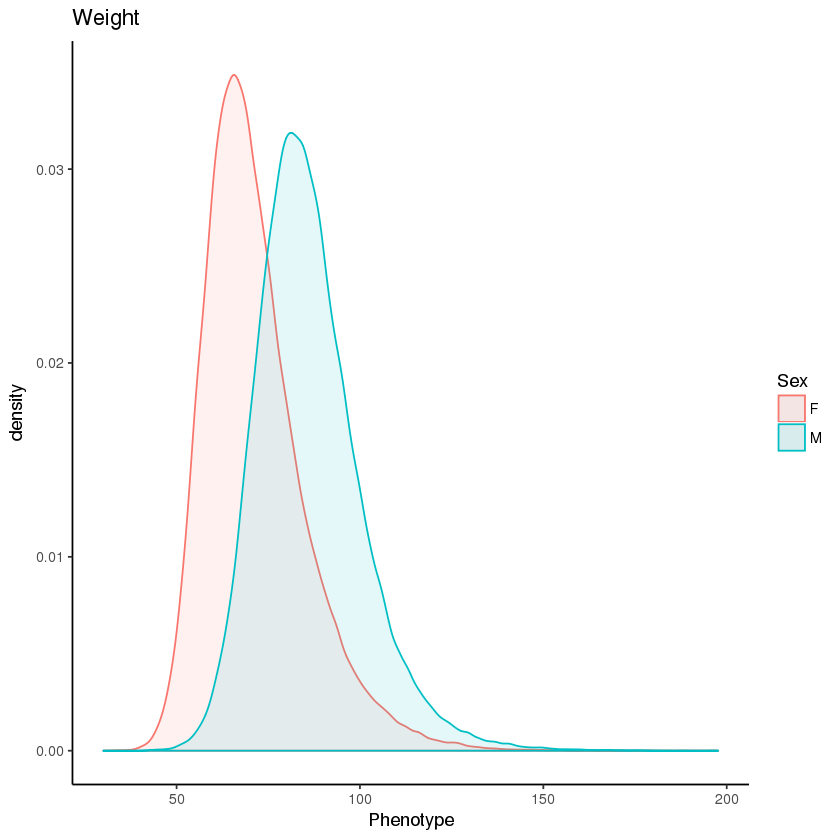

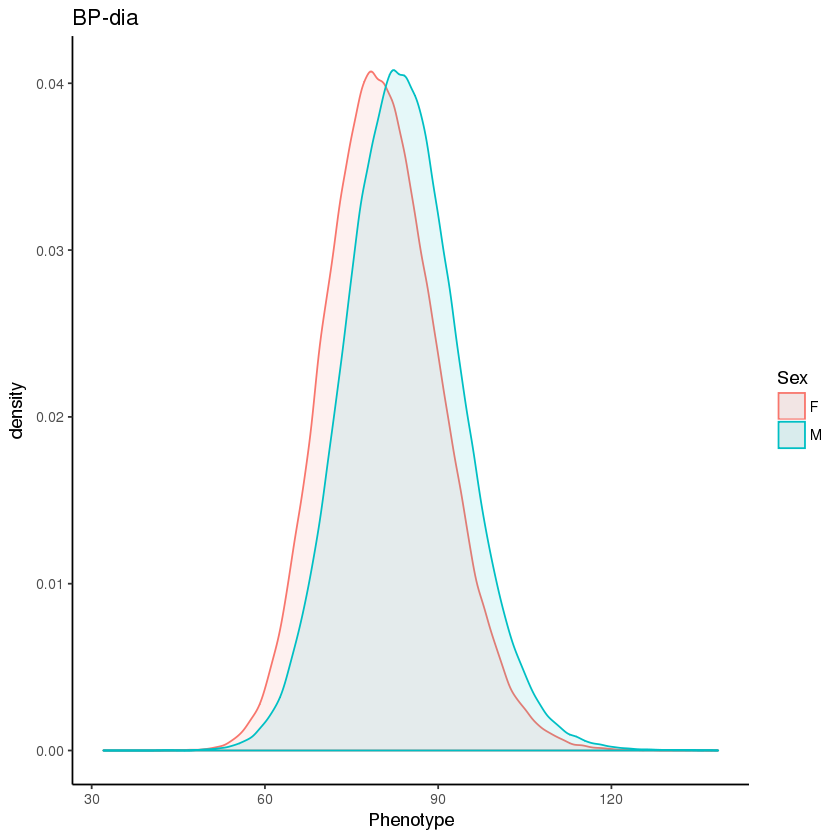

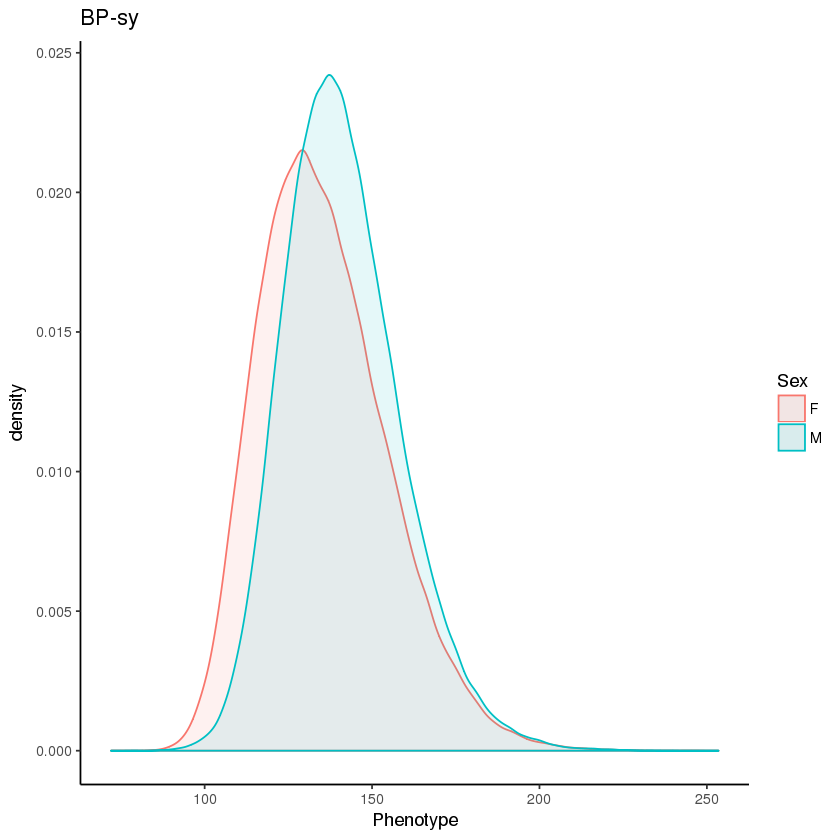

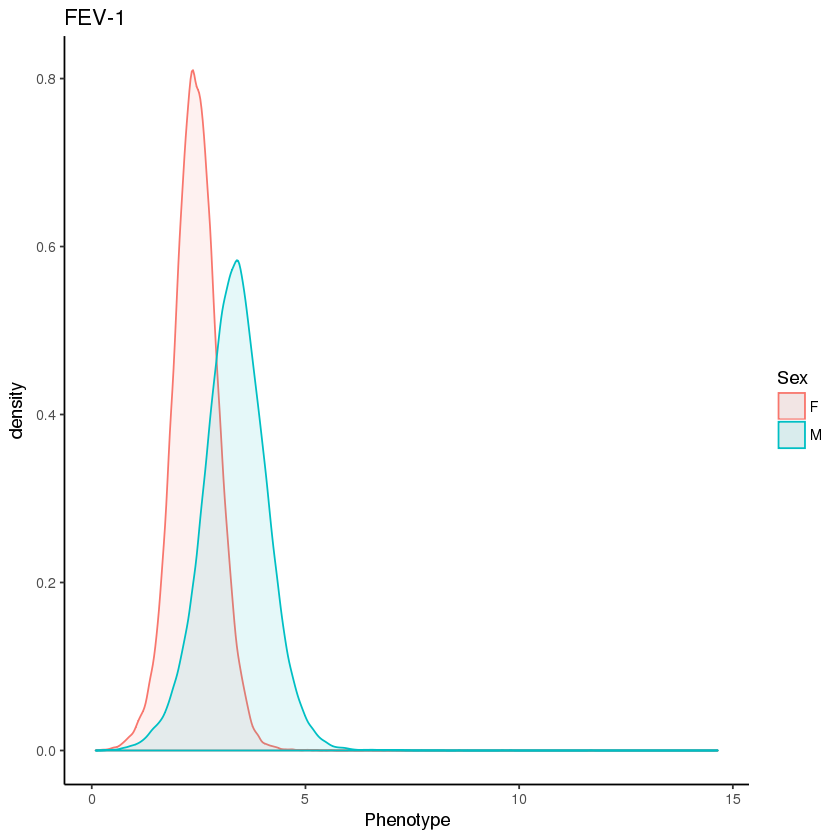

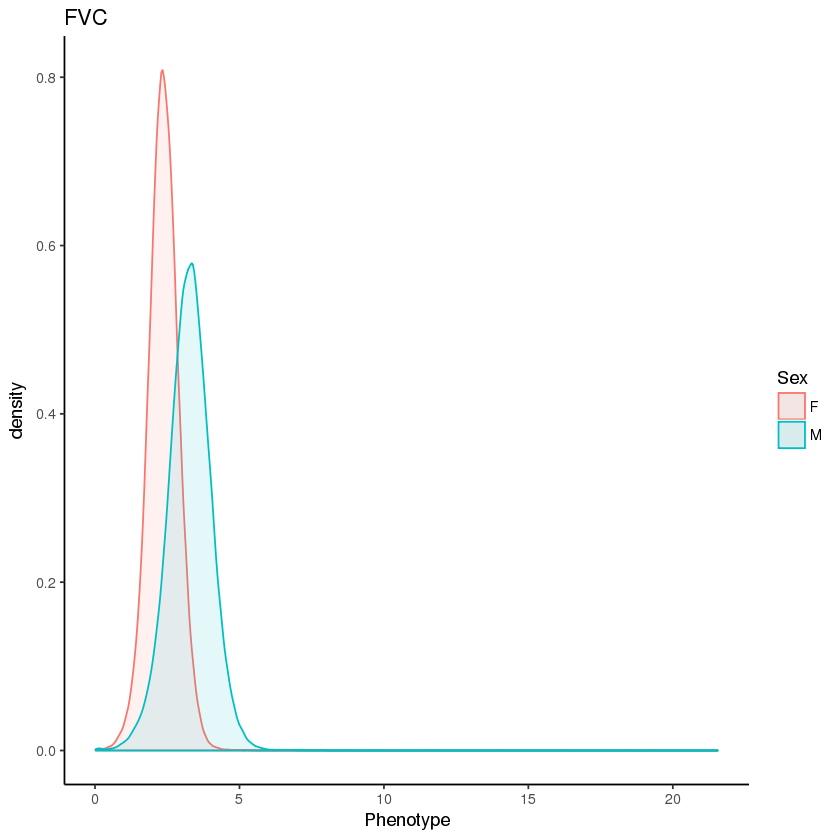

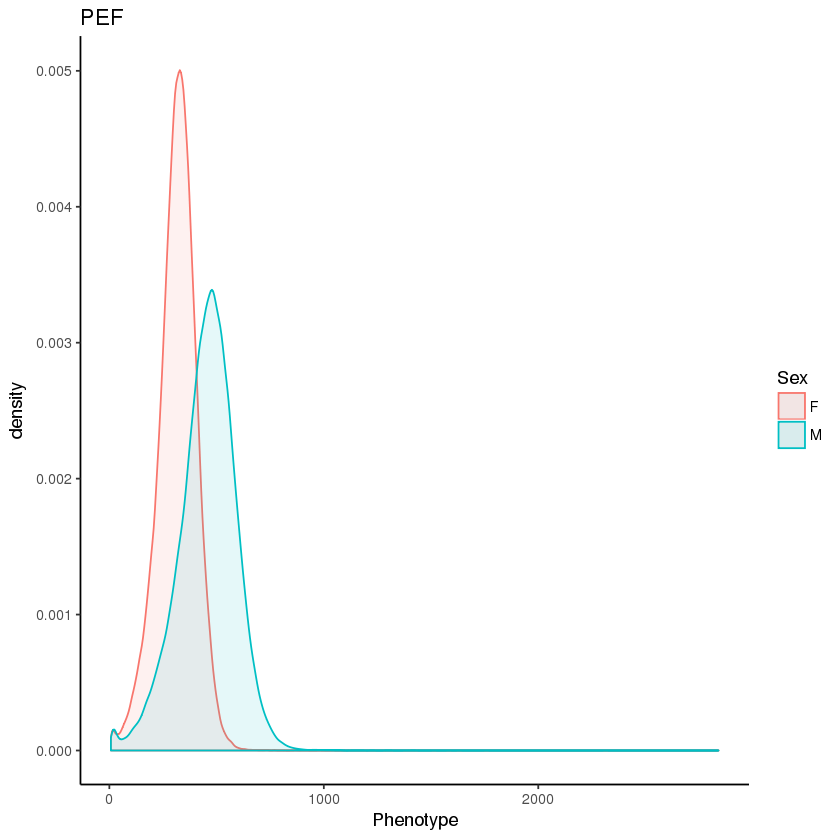

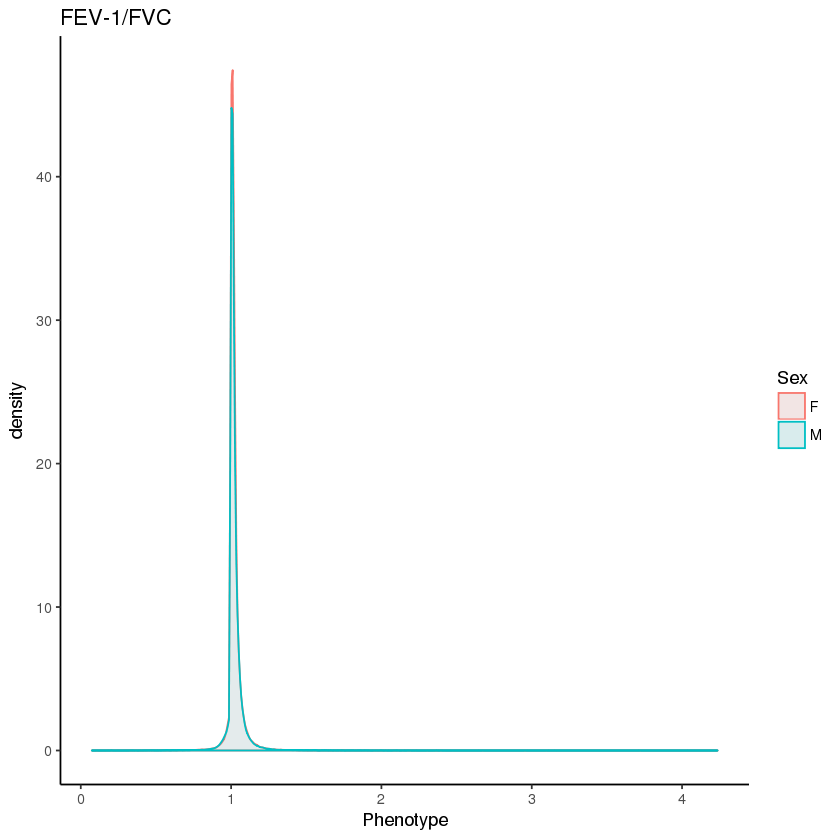

In [64]:
plotDensities("Waist circumference", phe48)
plotDensities("Hip circumference", phe49)
plotDensities("WHR", pheWhr)
plotDensities("BMI", phe21001)

plotDensities("Height", phe50)
plotDensities("Weight", phe21002)
plotDensities("BP-dia", phe4079)
plotDensities("BP-sy", phe4080)

plotDensities("FEV-1", phe20150)
plotDensities("FVC", phe3063)
plotDensities("PEF", phe3064)
plotDensities("FEV-1/FVC", pheFP.f)
